In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report

# Load and Preprocess the Dataset

In [17]:
# Load dataset
df = pd.read_csv("/kaggle/input/dataset-malicious-urls/malicious_phish.csv")  # Change this to your file path
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,legitimate
2,bopsecrets.org/rexroth/cr/1.htm,legitimate
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [19]:
df = df.iloc[:10000]
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,legitimate
2,bopsecrets.org/rexroth/cr/1.htm,legitimate
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [20]:
#Checking for Missing values
df.isnull().sum()

url     0
type    0
dtype: int64

In [21]:
#Checking target variable count
df["type"].value_counts()

type
legitimate    7325
defacement    1809
phishing       610
malware        256
Name: count, dtype: int64

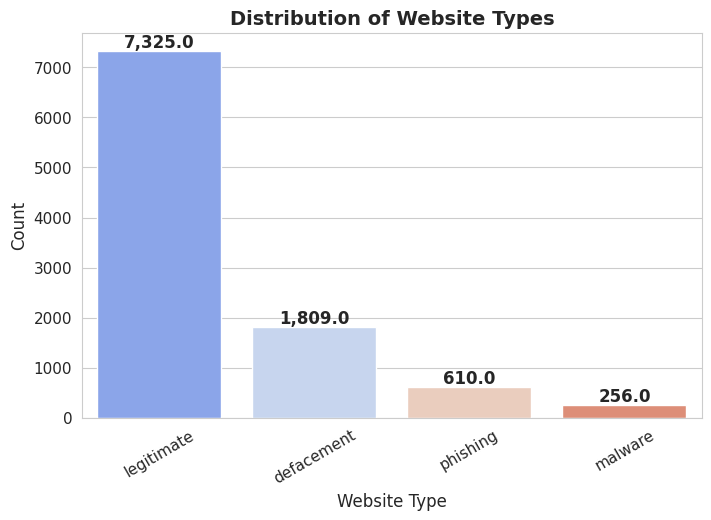

In [22]:
# Set seaborn style
sns.set_style("whitegrid")
# Create bar plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=df["type"].value_counts().index, y=df["type"].value_counts().values, palette='coolwarm')
# Add value labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize plot
plt.title("Distribution of Website Types", fontsize=14, fontweight='bold')
plt.xlabel("Website Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=30, fontsize=11)
plt.yticks(fontsize=11)
# Show plot
plt.show()

In [23]:
# Encode labels
label_mapping = {"legitimate": 0, "defacement": 1, "phishing": 2, "malware":3}
df["label"] = df["type"].map(label_mapping)

<ipython-input-23-389787005d16>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = df["type"].map(label_mapping)


In [24]:
df = df.drop("type", axis =1)

In [7]:
df.head()

,url,type,label
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,legitimate,0
2,bopsecrets.org/rexroth/cr/1.htm,legitimate,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [25]:
# Preprocessing: Replace special symbols
df["clean_url"] = df["url"].str.replace(r"[./-]", " ", regex=True)
df = df.drop("url", axis = 1)

In [26]:
#CLean dataset
df.head()

,label,clean_url
0,2,br icloud com br
1,0,mp3raid com music krizz_kaliko html
2,0,bopsecrets org rexroth cr 1 htm
3,1,http: www garage pirenne be index php?option=...
4,1,http: adventure nicaragua net index php?optio...


In [27]:
df.shape

(10000, 2)

In [ ]:
balanced_df["label"]

In [28]:
# Split into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["clean_url"], df["label"], test_size=0.2, random_state=42
)

In [29]:
# Tokenize URLs
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def encode_texts(texts, labels, max_length=128):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_length)
    return {key: tf.convert_to_tensor(val) for key, val in encodings.items()}, tf.convert_to_tensor(labels)

train_data, train_labels = encode_texts(train_texts, train_labels)
test_data, test_labels = encode_texts(test_texts, test_labels)

#  Define the BERT Model

In [30]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 4)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 109485316 (417.65 MB)
Trainable params: 109485316 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Train the Model

In [35]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(df["label"]), y=df["label"])
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.3412969283276451, 1: 1.3819789939192924, 2: 4.098360655737705, 3: 9.765625}


**Assigning higher weights to underrepresented classes.**

In [37]:
history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs= 5, batch_size= 64, class_weight=class_weight_dict)

Epoch 1/5
125/125 [==============================] - 239s 2s/step - loss: 0.3092 - accuracy: 0.9333 - val_loss: 0.2025 - val_accuracy: 0.9300
Epoch 2/5
125/125 [==============================] - 238s 2s/step - loss: 0.1664 - accuracy: 0.9759 - val_loss: 0.2559 - val_accuracy: 0.9260
Epoch 3/5
125/125 [==============================] - 238s 2s/step - loss: 0.1013 - accuracy: 0.9806 - val_loss: 0.2798 - val_accuracy: 0.9265
Epoch 4/5
125/125 [==============================] - 238s 2s/step - loss: 0.0476 - accuracy: 0.9916 - val_loss: 0.2245 - val_accuracy: 0.9525
Epoch 5/5
125/125 [==============================] - 237s 2s/step - loss: 0.0367 - accuracy: 0.9929 - val_loss: 0.2700 - val_accuracy: 0.9395


# Evaluate on the Test Set

In [38]:
test_loss, test_acc = model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {test_acc:.4f}")

63/63 [==============================] - 21s 333ms/step - loss: 0.2700 - accuracy: 0.9395
Test Accuracy: 0.9395


In [39]:
#Make predictions
preds = model.predict(test_data)
pred_labels = np.argmax(preds.logits, axis=1)  # Convert logits to class labels

63/63 [==============================] - 25s 351ms/step


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      1445
           1       0.94      0.99      0.96       360
           2       0.60      0.80      0.68       137
           3       0.90      0.79      0.84        58

    accuracy                           0.94      2000
   macro avg       0.86      0.88      0.86      2000
weighted avg       0.95      0.94      0.94      2000



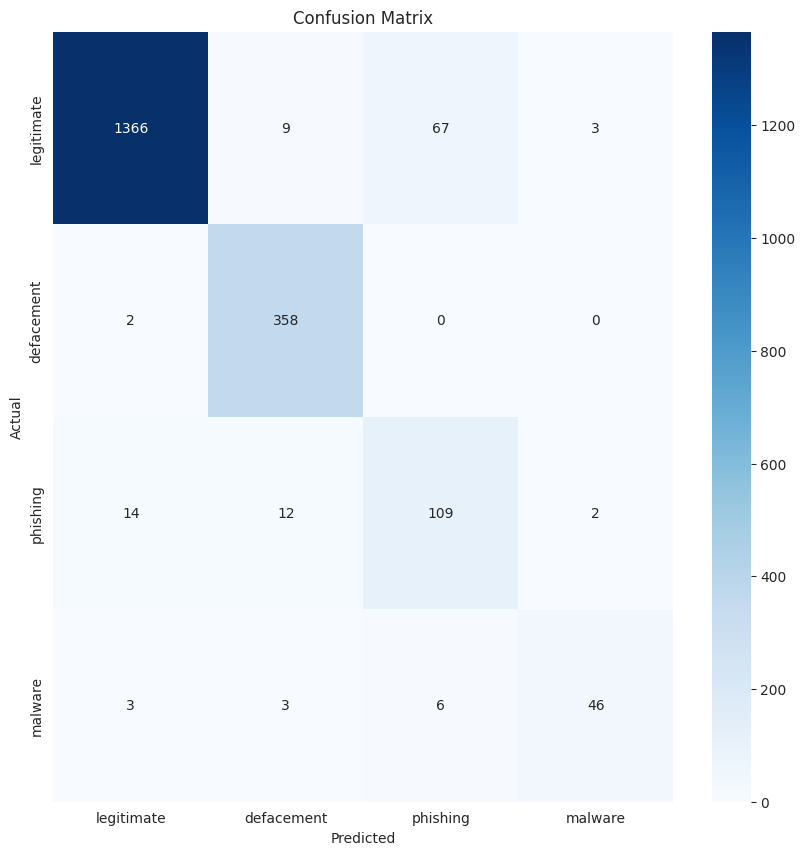

In [44]:
# Generate the confusion matrix
cm = confusion_matrix(test_labels, pred_labels)
# Classification report
print("Classification Report:\n", classification_report(test_labels, pred_labels))
# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["legitimate","defacement","phishing", "malware"], yticklabels=["legitimate","defacement","phishing", "malware"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# APPLYING ML MODELS LIKE RF AND XGBOOST

In [45]:
# Split into train & test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["clean_url"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

In [46]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 2))
# Fit and transform data
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [47]:
# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, train_labels)
# Check new class distribution
print(pd.Series(y_train_smote).value_counts())

label
0    5860
2    5860
1    5860
3    5860
Name: count, dtype: int64


**RANDOM FOREST**

In [48]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [49]:
# Make predictions
rf_preds = rf_model.predict(X_test)

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      1465
           1       0.88      0.96      0.92       362
           2       0.87      0.39      0.54       122
           3       0.97      0.75      0.84        51

    accuracy                           0.93      2000
   macro avg       0.92      0.77      0.82      2000
weighted avg       0.93      0.93      0.93      2000



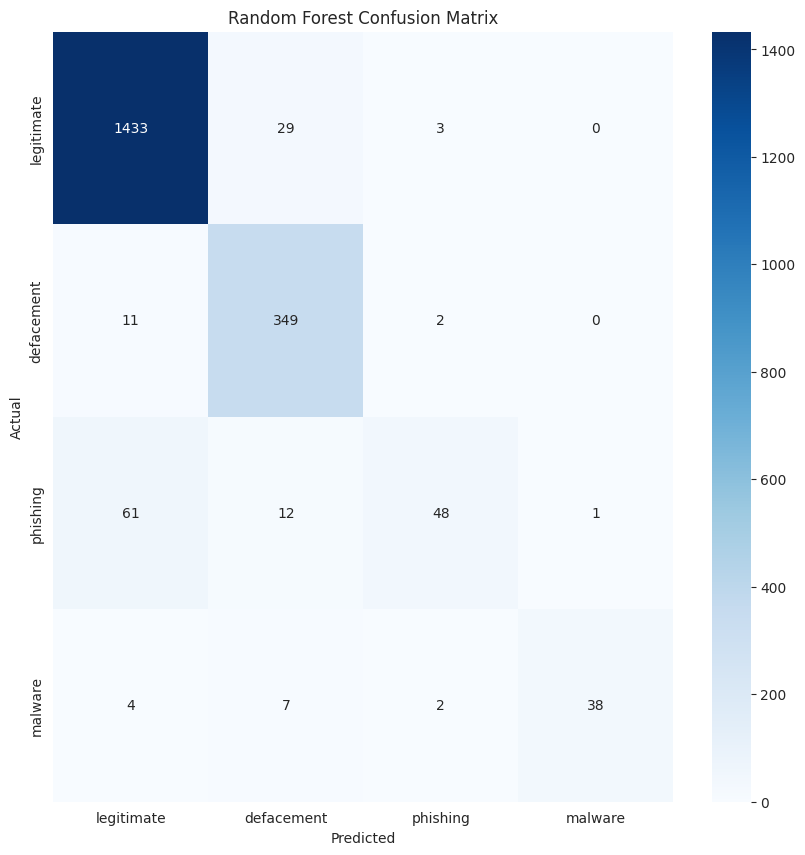

In [51]:
# Classification Report
print("Random Forest Classification Report:\n", classification_report(test_labels, rf_preds))
# Confusion Matrix
cm_rf = confusion_matrix(test_labels, rf_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["legitimate","defacement","phishing", "malware"], yticklabels=["legitimate","defacement","phishing", "malware"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

**XGBOOST MODEL**

In [52]:
# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [53]:
# Make predictions
xgb_preds = xgb_model.predict(X_test)

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      1465
           1       0.79      0.99      0.88       362
           2       0.50      0.43      0.46       122
           3       0.69      0.67      0.68        51

    accuracy                           0.89      2000
   macro avg       0.74      0.75      0.74      2000
weighted avg       0.89      0.89      0.89      2000



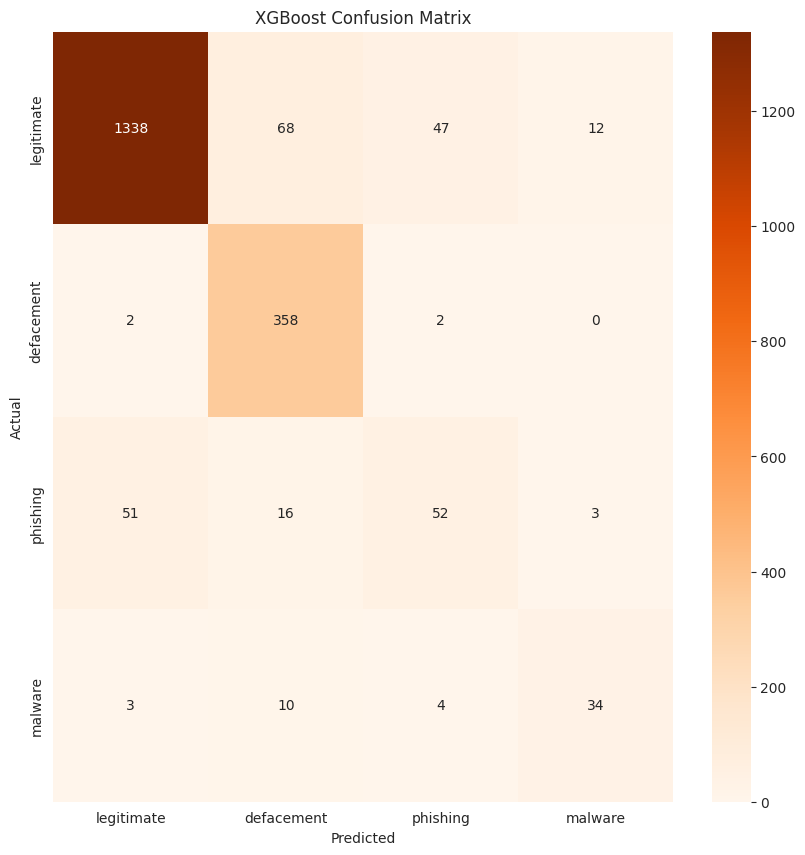

In [55]:
# Classification Report
print("XGBoost Classification Report:\n", classification_report(test_labels, xgb_preds))
# Confusion Matrix
cm_xgb = confusion_matrix(test_labels, xgb_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Oranges", xticklabels=["legitimate","defacement","phishing", "malware"], yticklabels=["legitimate","defacement","phishing", "malware"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

# USING Bi-LSTM a Deep learning algorithm

In [63]:
MAX_WORDS = 10000  # Vocabulary size
MAX_LENGTH = 100   # Maximum sequence length

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_texts)
X_test_seq = tokenizer.texts_to_sequences(test_texts)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding="post", truncating="post")

In [65]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_labels)  # Convert labels to numbers
y_test_encoded = label_encoder.transform(test_labels)

num_classes = len(label_encoder.classes_)  # Number of unique classes

In [68]:
EMBEDDING_DIM = 128

# Define Model
bl = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(num_classes, activation="softmax")  # Fix output shape
])
# Compile Model
bl.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
bl.build(input_shape=(None, MAX_LENGTH))
bl.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 100, 256)            │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,711,780 (6.53 MB)

 Trainable params: 1,711,780 (6.53 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Train Model
history = bl.fit(X_train_padded, y_train_encoded, epochs=10, batch_size = 64, validation_data=(X_test_padded, y_test_encoded))

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7784 - loss: 0.6763 - val_accuracy: 0.9070 - val_loss: 0.2386
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9321 - loss: 0.1965 - val_accuracy: 0.9395 - val_loss: 0.1897
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9528 - loss: 0.1318 - val_accuracy: 0.9375 - val_loss: 0.1610
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9678 - loss: 0.0905 - val_accuracy: 0.9470 - val_loss: 0.1589
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9753 - loss: 0.0722 - val_accuracy: 0.9520 - val_loss: 0.1477
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9790 - loss: 0.0565 - val_accuracy: 0.9505 - val_loss: 0.1529
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9774 - loss: 0.0665 - val_accuracy: 0.9535 - val_loss: 0.1528
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9807 - loss: 0.0606 - val_accu

In [70]:
# Get model predictions
y_pred_probs = bl.predict(X_test_padded)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


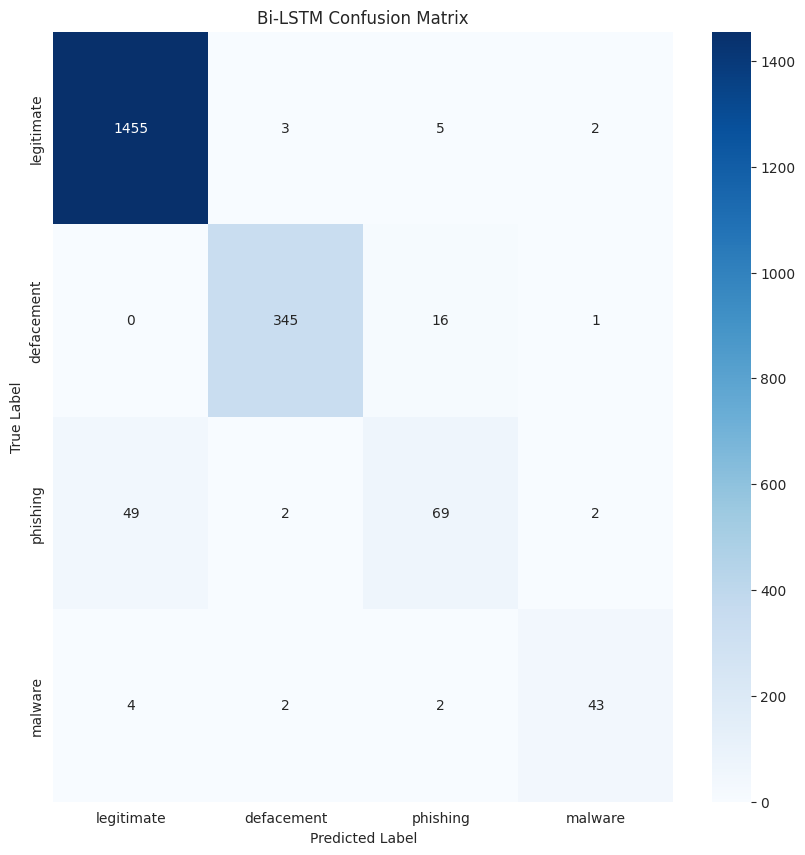

In [73]:
# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=["legitimate","defacement","phishing", "malware"], yticklabels=["legitimate","defacement","phishing", "malware"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Bi-LSTM Confusion Matrix")
plt.show()

In [75]:
# Print classification report
print(classification_report(y_test_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1465
           1       0.98      0.95      0.97       362
           2       0.75      0.57      0.64       122
           3       0.90      0.84      0.87        51

    accuracy                           0.96      2000
   macro avg       0.90      0.84      0.86      2000
weighted avg       0.95      0.96      0.95      2000

